### Data driven-research, Python project 2021/22
#### Subject: Analysis of Poles mobility in selected regions during COVID-19 pandemics



Authors: Jan Frąckowiak, Karolina Siwiec

In [2]:
# Importing required packages
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns                     

import matplotlib.pyplot as plt 
import plotly.express as px

In [3]:
import pandas as pd
import glob
import os

Mobility-related data source https://www.google.com/covid19/mobility/

Google lists mobility statistics in 6 areas: trade and recreation, grocery stores and pharmacies, parks, stations and stops, workplaces and places of residence. We assumed that the analysis of the first area will be the most interesting: trade and recreation (hereinafter: retail)

There are two parts to the project:
1) Analysis of the mutual relations of statistics at the Polish level, extended by an analysis of the relationship between data on infections and the severity of restrictions applied and mobility in shopping and entertainment facilities.
2) Analysis of data on mobility in retail and entertainment facilities at the voivodeship level: Dynamic cartogram built using geojson library. (defined in separate file: "Dynamic_cartogram.ipynb")

Loading data: csv file contains mobility data only in the selected retail sector. Data source: https://ourworldindata.org/covid-google-mobility-trends

### Part 1: Poland

In this part we will use 3 files:
1) Global_mobility_report containing mobility data (source: https://www.google.com/covid19/mobility/?fbclid=IwAR0RXwUdoPpdzvM82VA6PaxgDZnuuxOskpJm9vEbKtvytsPirt7jutToflE), report with global data
2) Stay-at-home_covid (source: https://ourworldindata.org/covid-stay-home-restrictions)
3) WHO-COVID showing statistics on the course of the pandemic (number of new cases, number of deaths)

In [97]:
# First file: mobility
# Data is not provided as it's size is 1GB
path = 'Google_all.csv'
df_mob=pd.read_csv(path)

/var/folders/qb/z1cbz14x723cj5l8lxt1k2f00000gn/T/ipykernel_60990/1399691832.py:3: DtypeWarning:

Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.



In [98]:
df_mob.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


In [99]:
# We leave only data for Poland and organize by removing redundant columns
df_mob=df_mob[(df_mob['country_region_code']=='PL')]

In [100]:
df_mob = df_mob[df_mob['iso_3166_2_code'].notna()]

In [101]:
df_mob = df_mob[['date', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline']]

In [102]:
df_mob.head()

,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
6240688,2020-02-15,20.0,-1.0,37.0,11.0,1.0,0.0
6240689,2020-02-16,10.0,-16.0,1.0,4.0,-4.0,1.0
6240690,2020-02-17,6.0,4.0,11.0,15.0,25.0,-2.0
6240691,2020-02-18,3.0,-2.0,4.0,0.0,2.0,1.0
6240692,2020-02-19,5.0,1.0,4.0,-1.0,2.0,0.0


In [103]:
# For each day, we take the average of the values ​​for the provinces
df_mob = df_mob.groupby('date').mean()

In [104]:
df_mob.shape

(856, 6)

In [105]:
# Second file: stay-at-home advice data: values ​​0-3
path = 'data/stay-at-home-covid.csv'
df_stay=pd.read_csv(path)

In [106]:
df_stay.head()

,Entity,Code,Day,stay_home_requirements
0,Afghanistan,AFG,2020-01-01,0
1,Afghanistan,AFG,2020-01-02,0
2,Afghanistan,AFG,2020-01-03,0
3,Afghanistan,AFG,2020-01-04,0
4,Afghanistan,AFG,2020-01-05,0


In [107]:
# Again, we only leave data for Poland
df_stay=df_stay[(df_stay['Code']=='POL')]

In [108]:
df_stay.describe()

# 0 - No measures
# 1 - Recommended not to leave the house
# 2 - Required to not leave the house with exceptions for daily exercise, grocery shopping, and ‘essential’ trips

,stay_home_requirements
count,886.000000
mean,0.577878
std,0.537967
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,2.000000


In [109]:
# Merging tables
df_merge=pd.merge(df_mob, df_stay, how="left", left_on = "date", right_on = "Day")

In [111]:
# Erasing NA's
df_merge = df_merge[df_merge['stay_home_requirements'].notna()]

In [4]:
# Third file: data on the course of the pandemic
path = 'data/WHO-COVID.csv'
df_cases=pd.read_csv(path)

In [114]:
df_cases.head()

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0
2,2020-01-05,AF,Afghanistan,EMRO,0,0,0,0
3,2020-01-06,AF,Afghanistan,EMRO,0,0,0,0
4,2020-01-07,AF,Afghanistan,EMRO,0,0,0,0


In [115]:
df_cases=df_cases[(df_cases['Country_code']=='PL')]

In [116]:
df_cases.describe()

,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
count,890.000000,8.900000e+02,890.000000,890.000000
mean,6752.501124,2.181828e+06,130.751685,49182.616854
std,9980.246471,2.021563e+06,189.720421,42572.397301
min,0.000000,0.000000e+00,0.000000,0.000000
25%,276.250000,5.313975e+04,6.000000,1823.250000
50%,974.500000,2.084042e+06,23.000000,49581.000000
75%,10728.000000,3.025424e+06,227.750000,77010.750000
max,57659.000000,6.009726e+06,954.000000,116369.000000


In [117]:
df_cases.tail()


,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
149515,2022-06-06,PL,Poland,EURO,53,6008665,0,116349
149516,2022-06-07,PL,Poland,EURO,338,6009003,6,116355
149517,2022-06-08,PL,Poland,EURO,202,6009205,7,116362
149518,2022-06-09,PL,Poland,EURO,274,6009479,6,116368
149519,2022-06-10,PL,Poland,EURO,247,6009726,1,116369


In [118]:
# Adding data on the course of the pandemic to the table
df_merge=pd.merge(df_merge, df_cases, how="left", left_on = "Day", right_on = "Date_reported")

In [119]:
df_merge.head()

,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Entity,Code,Day,stay_home_requirements,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,9.5625,-0.7500,25.8750,7.6875,0.8125,-0.7500,Poland,POL,2020-02-15,0.0,2020-02-15,PL,Poland,EURO,0,0,0,0
1,10.3750,-11.6250,11.8125,8.1250,-2.3750,0.1875,Poland,POL,2020-02-16,0.0,2020-02-16,PL,Poland,EURO,0,0,0,0
2,6.6875,2.8750,15.2500,9.6875,13.8750,-1.0625,Poland,POL,2020-02-17,0.0,2020-02-17,PL,Poland,EURO,0,0,0,0
3,3.6875,-0.8125,7.7500,2.0000,-1.5000,0.8750,Poland,POL,2020-02-18,0.0,2020-02-18,PL,Poland,EURO,0,0,0,0
4,5.0625,1.2500,9.5625,1.1875,-2.6250,0.6250,Poland,POL,2020-02-19,0.0,2020-02-19,PL,Poland,EURO,0,0,0,0


In [120]:
df_merge.shape

(841, 18)

In [121]:
# Deleting redundant columns
df_merge = df_merge[['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'Code', 'Day', 'stay_home_requirements', 'New_cases', 'Cumulative_cases', 'New_deaths', 'Cumulative_deaths']]

In [122]:
# We change the names of the columns so that "percent_change_from_baseline" is not repeated in each
df_merge.columns = ['retail', 'grocery', 'parks', 'transit', 'work', 'home', 'code', 'date', 'stay_home', 'new_cases', 'cumulative_cases', 'new_deaths', 'cumulative_deaths']

In [123]:
df_merge = df_merge[['code', 'date', 'retail', 'grocery', 'parks', 'transit', 'work', 'home', 'stay_home', 'new_cases', 'cumulative_cases', 'new_deaths', 'cumulative_deaths']]

In [124]:
df_merge.head()

,code,date,retail,grocery,parks,transit,work,home,stay_home,new_cases,cumulative_cases,new_deaths,cumulative_deaths
0,POL,2020-02-15,9.5625,-0.7500,25.8750,7.6875,0.8125,-0.7500,0.0,0,0,0,0
1,POL,2020-02-16,10.3750,-11.6250,11.8125,8.1250,-2.3750,0.1875,0.0,0,0,0,0
2,POL,2020-02-17,6.6875,2.8750,15.2500,9.6875,13.8750,-1.0625,0.0,0,0,0,0
3,POL,2020-02-18,3.6875,-0.8125,7.7500,2.0000,-1.5000,0.8750,0.0,0,0,0,0
4,POL,2020-02-19,5.0625,1.2500,9.5625,1.1875,-2.6250,0.6250,0.0,0,0,0,0


In [125]:
df_merge.tail()

,code,date,retail,grocery,parks,transit,work,home,stay_home,new_cases,cumulative_cases,new_deaths,cumulative_deaths
836,POL,2022-05-31,14.3750,36.0000,119.3125,27.5000,9.0625,-0.8750,0.0,346,6007584,7,116319
837,POL,2022-06-01,30.5000,38.6250,120.1875,28.8125,5.8750,-0.6250,0.0,256,6007840,7,116326
838,POL,2022-06-02,14.0625,34.0000,115.8125,26.1250,6.3125,-0.3750,0.0,219,6008059,7,116333
839,POL,2022-06-03,12.5000,34.9375,151.8125,30.8125,17.9375,-2.8750,0.0,236,6008295,5,116338
840,POL,2022-06-04,9.8125,26.8125,168.6250,35.3125,20.5000,-3.0625,0.0,255,6008550,11,116349


In [126]:
df_merge.describe()

,retail,grocery,parks,transit,work,home,stay_home,new_cases,cumulative_cases,new_deaths,cumulative_deaths
count,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,841.000000,8.410000e+02,841.000000,841.000000
mean,-7.883987,13.062044,61.104325,-8.808035,-11.140086,3.747622,0.608799,7144.530321,2.266078e+06,138.346017,51218.046373
std,25.298811,35.270590,74.848050,24.541267,19.391142,5.967970,0.534851,10130.179173,1.992408e+06,192.469609,41927.625557
min,-91.375000,-93.625000,-68.125000,-84.750000,-87.687500,-8.812500,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,-23.812500,-2.625000,4.562500,-27.875000,-23.125000,-0.125000,0.000000,318.000000,7.304700e+04,8.000000,2169.000000
50%,-1.937500,11.062500,36.625000,-5.937500,-10.312500,2.500000,1.000000,1350.000000,2.554508e+06,27.000000,58184.000000
75%,8.625000,25.562500,103.466667,8.937500,3.875000,7.250000,1.000000,11498.000000,3.093656e+06,247.000000,77747.000000
max,71.500000,216.800000,363.687500,60.312500,33.000000,32.500000,2.000000,57659.000000,6.008550e+06,954.000000,116349.000000


#### Section 1.1 Analysis of mobility trends in Poland

In [127]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Let's create subplots from the graphs presented above for individual areas of mobility

fig = make_subplots(rows=6, cols=1, subplot_titles=("Mobility: Retail and Leisure", 'Mobility - Groceries and Pharmacies', 'Mobility - Parks',
                                                    "Mobility - Stations and Stops", "Mobility - Workplaces", "Mobility - Place of Residence" ))

fig.append_trace(go.Scatter(
    x=df_merge['date'],
    y=df_merge['retail'],
), row=1, col=1)

fig.append_trace(go.Scatter(
    x=df_merge['date'],
    y=df_merge['grocery'],
), row=2, col=1)

fig.append_trace(go.Scatter(
    x=df_merge['date'],
    y=df_merge['parks'],
), row=3, col=1)

fig.append_trace(go.Scatter(
    x=df_merge['date'],
    y=df_merge['transit'],
), row=4, col=1)

fig.append_trace(go.Scatter(
    x=df_merge['date'],
    y=df_merge['work'],
), row=5, col=1)

fig.append_trace(go.Scatter(
    x=df_merge['date'],
    y=df_merge['home'],
), row=6, col=1)

fig.update_layout(showlegend=False, height=1800, width=1500)
fig.show()

#### Part 1.2 Stay-at-home

In [128]:
fig = px.line(df_merge, x='date', y='stay_home', title='Stay-at-home', height=400)
fig.show()

Let's compare the stay-at-home recommendations to your level of mobility. We assumed that the comparison with data on mobility in the retail category would be the most interesting

In [129]:
fig = make_subplots(rows=2, cols=1, subplot_titles=("Mobilność: handel i rozrywka", "Rekomendacje stay-at-home",))

fig.append_trace(go.Scatter(
    x=df_merge['date'],
    y=df_merge['retail'],
), row=1, col=1)

fig.append_trace(go.Scatter(
    x=df_merge['date'],
    y=df_merge['stay_home'],
), row=2, col=1)

fig.update_layout(showlegend=False, height=1000, width=1500)
fig.show()


Conclusion: lower mobility of Poles in the initial period of the pandemic, despite the recommendations to limit movement, we do not observe reduced mobility. Can we talk about Poles getting used to the pandemic? Adaptability to the pandemic reality

#### Part 1.3 Correlation analysis

Correlation between grocery and new_cases: PearsonRResult(statistic=-0.014609054610895506, pvalue=0.6722551127961296)
Correlation between retail and new_cases: PearsonRResult(statistic=-0.240365568043925, pvalue=1.617170661644018e-12)
Correlation between parks and new_cases: PearsonRResult(statistic=-0.42408550033826203, pvalue=4.883349541272037e-38)
Correlation between transit and new_cases: PearsonRResult(statistic=-0.21768522300322912, pvalue=1.7691986861747996e-10)
Correlation between work and new_cases: PearsonRResult(statistic=-0.043199289214258065, pvalue=0.21075199290698343)
Correlation between home and new_cases: PearsonRResult(statistic=0.26411754639733276, pvalue=6.878318224214027e-15)


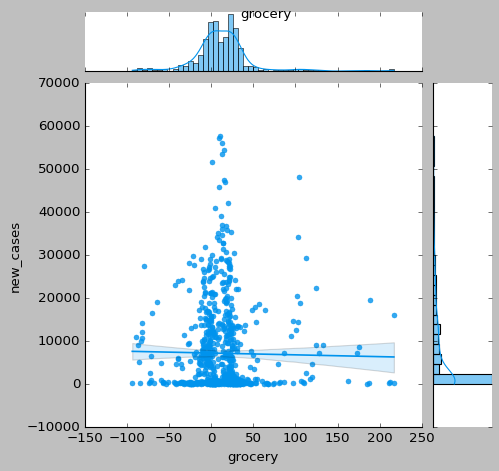

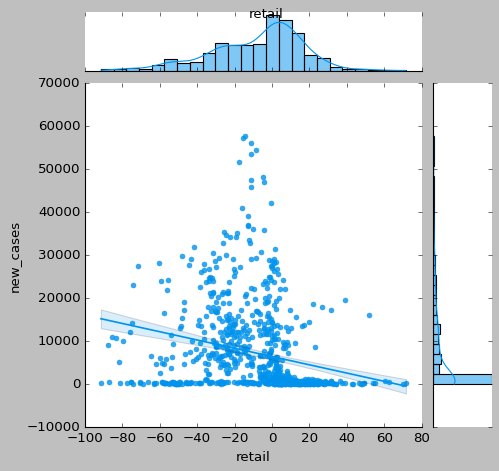

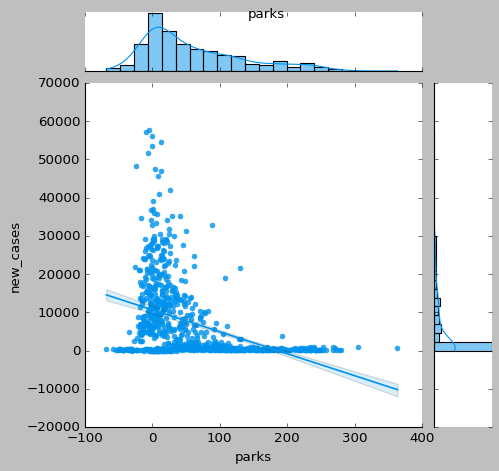

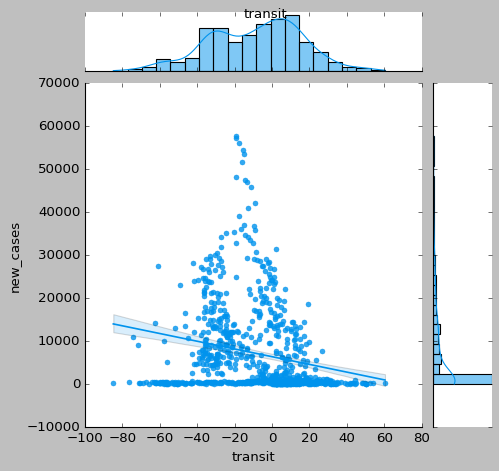

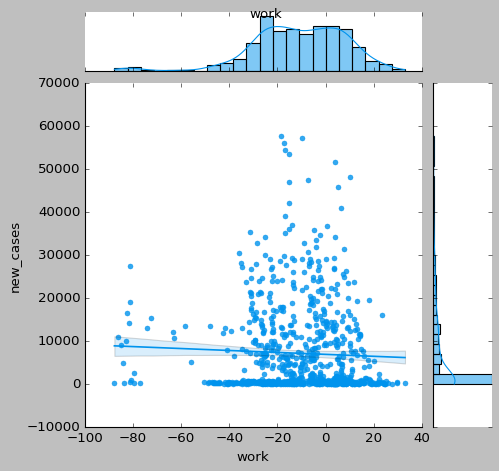

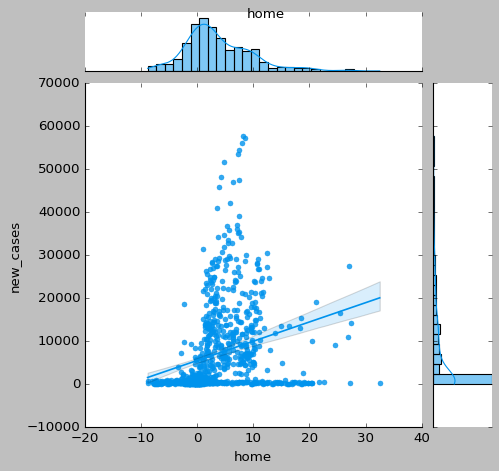

In [141]:
# Plot the relationship between mobility and new cases
for category in ['grocery', 'retail', 'parks', 'transit', 'work', 'home']:
    ax = sns.jointplot(x=category, y="new_cases", data=df_merge, color='#0093ED', kind='reg')
    ax.fig.suptitle(category)
    print(f"Correlation between {category} and new_cases: {sp.stats.pearsonr(df_merge[category], df_merge['new_cases'])}")

# Show the plots
plt.show()

#### Let's check the correlation of mobility measures with the parameters describing the course of the pandemic


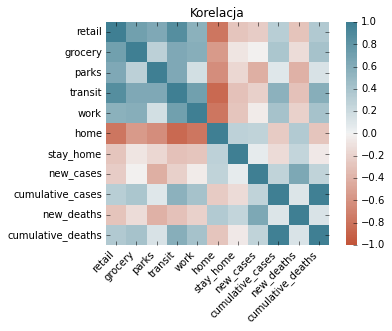

In [ ]:
corr2=df_merge2.corr()

ax = sns.heatmap(
    corr2, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
)
ax.set_title('Korelacja')
ax
plt.savefig('korelacja2.pdf')

Observation: none of the measures of mobility show a strong correlation with the number of new cases
Observation: Mobility in the place of is residence negatively correlated with other parameters, exception - stay-at-home recommendations (intuitive)

### Part 2: Poland - Voivodeships

Source files for provinces are 3 csv files. File names have a fixed structure rok_PL_Mobility

In [149]:
# Import pliku csv z danymi dot. mobilnosci
files = os.path.join('data/*PL_Mobility.csv')
files = glob.glob(files)

df_voi = pd.concat(map(pd.read_csv, files), ignore_index=True)

In [150]:
df_voi.describe()

,metro_area,census_fips_code,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
count,0.0,0.0,221167.000000,242896.000000,90240.000000,169639.000000,312973.000000,257055.000000
mean,NaN,NaN,-0.737710,13.109310,29.556693,-9.338360,-11.337908,3.874782
std,NaN,NaN,32.732954,33.772489,73.293761,34.050291,20.622002,5.981140
min,NaN,NaN,-100.000000,-100.000000,-98.000000,-94.000000,-93.000000,-34.000000
25%,NaN,NaN,-18.000000,-2.000000,-16.000000,-31.000000,-24.000000,0.000000
50%,NaN,NaN,0.000000,12.000000,13.000000,-12.000000,-11.000000,3.000000
75%,NaN,NaN,16.000000,28.000000,57.000000,8.000000,2.000000,7.000000
max,NaN,NaN,616.000000,461.000000,1187.000000,479.000000,170.000000,42.000000


In [151]:
df_voi.shape

(316395, 15)

In [152]:
df_voi.columns

Index(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2',
       'metro_area', 'iso_3166_2_code', 'census_fips_code', 'place_id', 'date',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')

Source files contain data for specific cities, our analysis includes only voivodeships, so we remove unnecessary columns.
The sub_region_1 column is key in our analysis, we also leave iso_3166_2_code

In [163]:
df_voi = df_voi[['sub_region_1', 'iso_3166_2_code', 'date',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline']]

In [164]:
#NA values
print(df_voi.isnull().sum())

sub_region_1                                             819
iso_3166_2_code                                       303291
date                                                       0
retail_and_recreation_percent_change_from_baseline     95228
grocery_and_pharmacy_percent_change_from_baseline      73499
parks_percent_change_from_baseline                    226155
transit_stations_percent_change_from_baseline         146756
workplaces_percent_change_from_baseline                 3422
residential_percent_change_from_baseline               59340
dtype: int64


In [165]:
# We leave only the line where iso_3166_2_code is not empty
# Then we have values ​​for individual provinces
df_voi = df_voi[df_voi['iso_3166_2_code'].notna()]

In [166]:
# We have a pre-ordered database, let's take a look at the descriptive statistics
df_voi.describe()

,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
count,13098.000000,12981.000000,12739.000000,13056.000000,13104.000000,13104.000000
mean,-8.515193,11.878977,58.670304,-9.881434,-11.836310,3.881487
std,27.051976,35.434076,94.383892,28.256011,20.422231,6.194296
min,-93.000000,-95.000000,-84.000000,-88.000000,-92.000000,-12.000000
25%,-25.000000,-4.000000,0.000000,-29.000000,-25.000000,0.000000
50%,-5.000000,9.000000,31.000000,-11.000000,-11.000000,3.000000
75%,7.000000,24.000000,89.000000,7.000000,3.000000,7.000000
max,152.000000,283.000000,786.000000,167.000000,41.000000,38.000000


In [1]:
# Import a csv file with data on voivodship codes
# The file also contains Polish names of provinces
path = 'data/codes.csv'
df_codes=pd.read_csv(path, sep = ';')

NameError: name 'pd' is not defined

We combine the table with mobility data with the table with voivodship codes and Polish names

In [235]:
df_final=pd.merge(df_voi, df_codes, how="left", left_on = "iso_3166_2_code", right_on = "KOD_ISO")

In [236]:
fig = px.histogram(df_final, 
                   x="retail_and_recreation_percent_change_from_baseline", 
                   marginal="violin",
                   )
plt.tight_layout() 
fig.show()

<Figure size 640x480 with 0 Axes>

In [237]:
df_final.head()

,sub_region_1,iso_3166_2_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,KOD_ISO,Nazwa,ID
0,Greater Poland Voivodeship,PL-30,2022-01-01,-80.0,-84.0,3.0,-49.0,-70.0,12.0,PL-30,wielkopolskie,3
1,Greater Poland Voivodeship,PL-30,2022-01-02,-30.0,81.0,4.0,-15.0,-8.0,4.0,PL-30,wielkopolskie,3
2,Greater Poland Voivodeship,PL-30,2022-01-03,-12.0,12.0,-7.0,-21.0,-4.0,8.0,PL-30,wielkopolskie,3
3,Greater Poland Voivodeship,PL-30,2022-01-04,-9.0,14.0,1.0,-30.0,-19.0,9.0,PL-30,wielkopolskie,3
4,Greater Poland Voivodeship,PL-30,2022-01-05,5.0,47.0,16.0,-24.0,-21.0,6.0,PL-30,wielkopolskie,3


In [238]:
df_final = df_final.drop(columns = ['KOD_ISO', 'ID'])

In [239]:
df_final.columns = ['sub_region', 'iso_code', 'date', 'retail', 'grocery', 'parks', 'transit', 'work', 'home', 'name' ]

In [240]:
df_final.head()

,sub_region,iso_code,date,retail,grocery,parks,transit,work,home,name
0,Greater Poland Voivodeship,PL-30,2022-01-01,-80.0,-84.0,3.0,-49.0,-70.0,12.0,wielkopolskie
1,Greater Poland Voivodeship,PL-30,2022-01-02,-30.0,81.0,4.0,-15.0,-8.0,4.0,wielkopolskie
2,Greater Poland Voivodeship,PL-30,2022-01-03,-12.0,12.0,-7.0,-21.0,-4.0,8.0,wielkopolskie
3,Greater Poland Voivodeship,PL-30,2022-01-04,-9.0,14.0,1.0,-30.0,-19.0,9.0,wielkopolskie
4,Greater Poland Voivodeship,PL-30,2022-01-05,5.0,47.0,16.0,-24.0,-21.0,6.0,wielkopolskie


#### Section 2.1 Let's Analyze "Extreme" Values

In [241]:
max_df_retail = df_final.groupby('name')['retail'].max().reset_index()

In [242]:
max_df_retail.sort_values('retail', ascending = False)[['name', 'retail']].style.background_gradient(cmap='Oranges')

,name,retail
15,zachodniopomorskie,152.000000
13,warminsko-mazurskie,108.000000
7,opolskie,93.000000
3,lubelskie,88.000000
8,podkarpackie,88.000000
1,kujawsko-pomorskie,87.000000
9,podlaskie,85.000000
10,pomorskie,85.000000
2,lodzkie,75.000000
12,swietokrzyskie,74.000000


In [245]:
min_df_retail = df_final.groupby('name')['retail'].min().reset_index()

In [246]:
min_df_retail.sort_values('retail', ascending = True)[['name', 'retail']].style.background_gradient(cmap='Blues')

,name,retail
5,malopolskie,-93.000000
8,podkarpackie,-93.000000
9,podlaskie,-93.000000
3,lubelskie,-92.000000
11,slaskie,-92.000000
12,swietokrzyskie,-92.000000
14,wielkopolskie,-92.000000
0,dolnoslaskie,-91.000000
1,kujawsko-pomorskie,-91.000000
6,mazowieckie,-91.000000


In [247]:
max_df_grocery = df_final.groupby('name')['grocery'].max().reset_index()

In [248]:
max_df_grocery.sort_values('grocery', ascending = False)[['name', 'grocery']].style.background_gradient(cmap='Oranges')

,name,grocery
7,opolskie,283.000000
15,zachodniopomorskie,248.000000
13,warminsko-mazurskie,246.000000
2,lodzkie,239.000000
12,swietokrzyskie,239.000000
9,podlaskie,235.000000
10,pomorskie,232.000000
11,slaskie,231.000000
3,lubelskie,220.000000
8,podkarpackie,219.000000


In [249]:
min_df_grocery = df_final.groupby('name')['grocery'].min().reset_index()

In [251]:
min_df_grocery.sort_values('grocery', ascending = True)[['name', 'grocery']].style.background_gradient(cmap='Blues')

,name,grocery
7,opolskie,-95.000000
8,podkarpackie,-95.000000
0,dolnoslaskie,-94.000000
3,lubelskie,-94.000000
5,malopolskie,-94.000000
9,podlaskie,-94.000000
11,slaskie,-94.000000
14,wielkopolskie,-94.000000
15,zachodniopomorskie,-94.000000
1,kujawsko-pomorskie,-93.000000


In [252]:
max_df_parks = df_final.groupby('name')['parks'].max().reset_index()

In [253]:
max_df_parks.sort_values('parks', ascending = False)[['name', 'parks']].style.background_gradient(cmap='Oranges')

,name,parks
13,warminsko-mazurskie,786.000000
15,zachodniopomorskie,700.000000
10,pomorskie,593.000000
9,podlaskie,454.000000
8,podkarpackie,431.000000
1,kujawsko-pomorskie,390.000000
12,swietokrzyskie,385.000000
11,slaskie,383.000000
4,lubuskie,337.000000
7,opolskie,328.000000


In [254]:
min_df_parks = df_final.groupby('name')['parks'].min().reset_index()

In [255]:
min_df_parks.sort_values('parks', ascending = True)[['name', 'parks']].style.background_gradient(cmap='Blues')

,name,parks
5,malopolskie,-84.000000
10,pomorskie,-78.000000
15,zachodniopomorskie,-76.000000
0,dolnoslaskie,-73.000000
1,kujawsko-pomorskie,-73.000000
6,mazowieckie,-72.000000
11,slaskie,-72.000000
7,opolskie,-71.000000
2,lodzkie,-70.000000
12,swietokrzyskie,-66.000000


In [256]:
max_df_transit = df_final.groupby('name')['transit'].max().reset_index()

In [258]:
max_df_transit.sort_values('transit', ascending = False)[['name', 'transit']].style.background_gradient(cmap='Oranges')

,name,transit
7,opolskie,167.000000
1,kujawsko-pomorskie,141.000000
4,lubuskie,116.000000
8,podkarpackie,110.000000
15,zachodniopomorskie,97.000000
10,pomorskie,88.000000
12,swietokrzyskie,84.000000
3,lubelskie,57.000000
13,warminsko-mazurskie,57.000000
11,slaskie,55.000000


In [259]:
min_df_transit = df_final.groupby('name')['transit'].min().reset_index()

In [260]:
min_df_transit.sort_values('transit', ascending = True)[['name', 'transit']].style.background_gradient(cmap='Blues')

,name,transit
0,dolnoslaskie,-88.000000
5,malopolskie,-88.000000
6,mazowieckie,-88.000000
3,lubelskie,-87.000000
7,opolskie,-86.000000
8,podkarpackie,-86.000000
10,pomorskie,-86.000000
1,kujawsko-pomorskie,-85.000000
14,wielkopolskie,-85.000000
2,lodzkie,-84.000000


In [263]:
max_df_work = df_final.groupby('name')['work'].max().reset_index()

In [264]:
max_df_work.sort_values('work', ascending = False)[['name', 'work']].style.background_gradient(cmap='Oranges')

,name,work
2,lodzkie,41.000000
4,lubuskie,41.000000
10,pomorskie,41.000000
13,warminsko-mazurskie,41.000000
8,podkarpackie,40.000000
3,lubelskie,39.000000
1,kujawsko-pomorskie,38.000000
9,podlaskie,38.000000
12,swietokrzyskie,37.000000
6,mazowieckie,35.000000


In [265]:
min_df_work = df_final.groupby('name')['work'].min().reset_index()

In [266]:
min_df_work.sort_values('work', ascending = True)[['name', 'work']].style.background_gradient(cmap='Blues')

,name,work
6,mazowieckie,-92.000000
0,dolnoslaskie,-90.000000
5,malopolskie,-89.000000
7,opolskie,-89.000000
14,wielkopolskie,-89.000000
1,kujawsko-pomorskie,-88.000000
2,lodzkie,-88.000000
8,podkarpackie,-88.000000
10,pomorskie,-88.000000
11,slaskie,-88.000000


In [267]:
max_df_home = df_final.groupby('name')['home'].max().reset_index()

In [268]:
max_df_home.sort_values('home', ascending = False)[['name', 'home']].style.background_gradient(cmap='Oranges')

,name,home
6,mazowieckie,38.000000
0,dolnoslaskie,35.000000
5,malopolskie,34.000000
11,slaskie,34.000000
14,wielkopolskie,34.000000
2,lodzkie,33.000000
7,opolskie,33.000000
10,pomorskie,33.000000
15,zachodniopomorskie,33.000000
1,kujawsko-pomorskie,31.000000


In [269]:
min_df_home = df_final.groupby('name')['home'].min().reset_index()

In [272]:
min_df_home.sort_values('home', ascending = True)[['name', 'home']].style.background_gradient(cmap='Blues')

,name,home
9,podlaskie,-12.000000
6,mazowieckie,-11.000000
13,warminsko-mazurskie,-11.000000
1,kujawsko-pomorskie,-10.000000
2,lodzkie,-10.000000
10,pomorskie,-10.000000
12,swietokrzyskie,-10.000000
0,dolnoslaskie,-9.000000
3,lubelskie,-9.000000
5,malopolskie,-9.000000


#### Section 2.2 Retail Mobility and Stay-at-Home Recommendations

In the second part, we talked about the stay-at-home parameter describing restrictions/suggestions regarding staying at home. Based on this data, we can determine the periods of validity of the "stay at home" suggestion, etc. In the specified periods, let's calculate the average mobility in the area of ​​\u200b\u200btrade in individual provinces

In [273]:
df_stay.loc[df_stay['stay_home_requirements'] == 2]
# Period with restriction 2: 2020-03-31 - 2020-04-19

,Entity,Code,Day,stay_home_requirements
116403,Poland,POL,2020-03-31,2
116404,Poland,POL,2020-04-01,2
116405,Poland,POL,2020-04-02,2
116406,Poland,POL,2020-04-03,2
116407,Poland,POL,2020-04-04,2
116408,Poland,POL,2020-04-05,2
116409,Poland,POL,2020-04-06,2
116410,Poland,POL,2020-04-07,2
116411,Poland,POL,2020-04-08,2
116412,Poland,POL,2020-04-09,2


In [274]:
df_stay.loc[df_stay['stay_home_requirements'] == 1]
# Period with restriction 1.1: 2020-04-20 - 2020-05-29
# Period with restriction 1.2: 2020-10-24 - 2021-12-29

,Entity,Code,Day,stay_home_requirements
116423,Poland,POL,2020-04-20,1
116424,Poland,POL,2020-04-21,1
116425,Poland,POL,2020-04-22,1
116426,Poland,POL,2020-04-23,1
116427,Poland,POL,2020-04-24,1
...,...,...,...,...
117037,Poland,POL,2021-12-25,1
117038,Poland,POL,2021-12-26,1
117039,Poland,POL,2021-12-27,1
117040,Poland,POL,2021-12-28,1


### We limit the table with mobility data to only the selected time period (where stay-at-home = 2)

In [275]:
df_final_2 = df_final[(df_final['date']>='2020-03-31') & (df_final['date']<='2020-04-19')]

In [276]:
df_final_2

,sub_region,iso_code,date,retail,grocery,parks,transit,work,home,name
2173,Greater Poland Voivodeship,PL-30,2020-03-31,-51.0,-23.0,-34.0,-63.0,-44.0,20.0,wielkopolskie
2174,Greater Poland Voivodeship,PL-30,2020-04-01,-55.0,-34.0,-33.0,-63.0,-45.0,21.0,wielkopolskie
2175,Greater Poland Voivodeship,PL-30,2020-04-02,-56.0,-33.0,-39.0,-65.0,-46.0,21.0,wielkopolskie
2176,Greater Poland Voivodeship,PL-30,2020-04-03,-56.0,-32.0,-43.0,-66.0,-44.0,23.0,wielkopolskie
2177,Greater Poland Voivodeship,PL-30,2020-04-04,-69.0,-42.0,-39.0,-63.0,-32.0,16.0,wielkopolskie
...,...,...,...,...,...,...,...,...,...,...
7003,West Pomeranian Voivodeship,PL-32,2020-04-15,-49.0,-35.0,-53.0,-52.0,-42.0,18.0,zachodniopomorskie
7004,West Pomeranian Voivodeship,PL-32,2020-04-16,-52.0,-35.0,-45.0,-53.0,-41.0,18.0,zachodniopomorskie
7005,West Pomeranian Voivodeship,PL-32,2020-04-17,-51.0,-30.0,-44.0,-53.0,-39.0,18.0,zachodniopomorskie
7006,West Pomeranian Voivodeship,PL-32,2020-04-18,-66.0,-40.0,-46.0,-47.0,-19.0,10.0,zachodniopomorskie


In [277]:
df_final_2_retail = df_final_2.drop(columns = ['iso_code', 'grocery', 'parks', 'transit', 'work', 'home'])

In [278]:
df_final_2_retail.groupby(['name']).agg({'retail':[np.mean, np.std]})

retail           
                      mean        std
name                                 
dolnoslaskie        -63.30  12.213452
kujawsko-pomorskie  -58.60  13.620418
lodzkie             -57.55  13.574260
lubelskie           -64.25  11.529710
lubuskie            -54.75  14.538063
malopolskie         -68.90  11.506977
mazowieckie         -64.10  11.625290
opolskie            -58.95  13.877187
podkarpackie        -64.45  11.798640
podlaskie           -63.65  12.995040
pomorskie           -61.80  12.988254
slaskie             -60.95  13.543206
swietokrzyskie      -62.45  13.176834
warminsko-mazurskie -58.40  13.601084
wielkopolskie       -59.75  13.687778
zachodniopomorskie  -59.90  13.285924

Average mobility in voivodeships in the area of ​​​​trade in the period of the recommendation "Required not to leave the house, except in necessary cases"

In [283]:
df_final_2_retail.groupby(['name']).agg({'retail':[np.median, np.std]})

retail           
                    median        std
name                                 
dolnoslaskie         -59.0  12.213452
kujawsko-pomorskie   -54.5  13.620418
lodzkie              -54.0  13.574260
lubelskie            -60.5  11.529710
lubuskie             -50.0  14.538063
malopolskie          -64.5  11.506977
mazowieckie          -60.5  11.625290
opolskie             -54.0  13.877187
podkarpackie         -60.5  11.798640
podlaskie            -59.0  12.995040
pomorskie            -57.5  12.988254
slaskie              -56.5  13.543206
swietokrzyskie       -57.5  13.176834
warminsko-mazurskie  -54.5  13.601084
wielkopolskie        -55.0  13.687778
zachodniopomorskie   -55.5  13.285924

In [299]:
numeric_cols = df_final_2_retail.select_dtypes(include='number').columns
df_retail_mean_2 = df_final_2_retail.groupby('name')[numeric_cols].mean().reset_index()

In [300]:
df_retail_mean_2

,name,retail
0,dolnoslaskie,-63.30
1,kujawsko-pomorskie,-58.60
2,lodzkie,-57.55
3,lubelskie,-64.25
4,lubuskie,-54.75
5,malopolskie,-68.90
6,mazowieckie,-64.10
7,opolskie,-58.95
8,podkarpackie,-64.45
9,podlaskie,-63.65


In [301]:
fig = px.line_polar(df_retail_mean_2, r='retail', theta='name', line_close=True, title="Mobilność w obszarze handlu w okresie 2020-03-31 - 2020-04-19", range_r = [-70, -50], width=800, height=600)
fig.update_traces(fill='toself')
fig.show()

In [302]:
df_final_1_1 = df_final[(df_final['date']>='2020-04-20') & (df_final['date']<='2020-05-29')]

In [310]:
df_final_1_1_retail = df_final_1_1.drop(columns = ['iso_code', 'grocery', 'parks', 'transit', 'work', 'home'])

In [311]:
numeric_cols = df_final_1_1_retail.select_dtypes(include='number').columns
df_retail_mean_1_1 = df_final_2_retail.groupby('name')[numeric_cols].mean().reset_index()

In [312]:
df_retail_mean_1_1

,name,retail
0,dolnoslaskie,-63.30
1,kujawsko-pomorskie,-58.60
2,lodzkie,-57.55
3,lubelskie,-64.25
4,lubuskie,-54.75
5,malopolskie,-68.90
6,mazowieckie,-64.10
7,opolskie,-58.95
8,podkarpackie,-64.45
9,podlaskie,-63.65


In [313]:
df_final_1_1_retail.groupby(['name']).agg({'retail':[np.median, np.std]})

retail           
                    median        std
name                                 
dolnoslaskie         -36.0  14.859837
kujawsko-pomorskie   -27.5  16.046407
lodzkie              -27.0  16.279588
lubelskie            -32.0  14.951867
lubuskie             -23.0  16.002384
malopolskie          -43.0  14.202835
mazowieckie          -38.0  14.804279
opolskie             -28.0  16.718464
podkarpackie         -31.5  15.560449
podlaskie            -30.0  15.928043
pomorskie            -31.0  16.730883
slaskie              -31.5  16.118153
swietokrzyskie       -31.0  15.613747
warminsko-mazurskie  -25.5  16.163825
wielkopolskie        -28.5  15.465760
zachodniopomorskie   -28.0  15.961311

In [315]:
fig = px.line_polar(df_retail_mean_1_1, r='retail', theta='name', line_close=True, title="Mobilność w obszarze handlu w okresie 2020-04-20 - 2020-05-29", range_r = [-70, -50], width=800, height=600)
fig.update_traces(fill='toself')

In [317]:
df_final_1_2 = df_final[(df_final['date']>='2020-10-24') & (df_final['date']<='2021-12-29')]

In [318]:
df_final_1_2_retail = df_final_1_2.drop(columns = ['iso_code', 'grocery', 'parks', 'transit', 'work', 'home'])

In [320]:
numeric_cols = df_final_1_2_retail.select_dtypes(include='number').columns
df_retail_mean_1_2 = df_final_1_2_retail.groupby('name')[numeric_cols].mean().reset_index()

In [321]:
fig = px.line_polar(df_retail_mean_1_2, r='retail', theta='name', line_close=True, title="Mobilność w obszarze handlu w okresie 2020-10-24 - 2021-12-29", range_r = [-20, 10], width=800, height=600)
fig.update_traces(fill='toself')
fig.show()

Despite type 1 recommendations, we do not observe a significant decrease in mobility in subsequent periods